* [Excercise 5.8. Racetrack](#Excercise-5.8.-Racetrack)

## Excercise 5.8. Racetrack

In [1]:
from collections import namedtuple
import random
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Track definitions were copied from https://github.com/jkillingsworth/ReinforcementLearning/blob/master/chapter05/Racetrack/Track.fs

In [2]:
MAX_SPEED = 4
N_ACTIONS = 3  # number of actions along x and y: 0, 1, -1

In [3]:
track1 = """
                  
   XXXXXXXXXXXXXF 
  XXXXXXXXXXXXXXF 
  XXXXXXXXXXXXXXF 
 XXXXXXXXXXXXXXXF 
XXXXXXXXXXXXXXXXF 
XXXXXXXXXXXXXXXXF 
XXXXXXXXXX        
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
XXXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
 XXXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
  XXXXXXX         
   XXXXXX         
   XXXXXX         
   SSSSSS         
"""

In [4]:
track2 = """
                                 
                XXXXXXXXXXXXXXXF 
             XXXXXXXXXXXXXXXXXXF 
            XXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
           XXXXXXXXXXXXXXXXXXXXF 
            XXXXXXXXXXXXXXXXXXXF 
             XXXXXXXXXXXXXXXXXXF 
              XXXXXXXXXXXXXXXX   
              XXXXXXXXXXXXX      
              XXXXXXXXXXXX       
              XXXXXXXXXX         
              XXXXXXXXX          
             XXXXXXXXXX          
            XXXXXXXXXXX          
           XXXXXXXXXXXX          
          XXXXXXXXXXXXX          
         XXXXXXXXXXXXXX          
        XXXXXXXXXXXXXXX          
       XXXXXXXXXXXXXXXX          
      XXXXXXXXXXXXXXXXX          
     XXXXXXXXXXXXXXXXXX          
    XXXXXXXXXXXXXXXXXXX          
   XXXXXXXXXXXXXXXXXXXX          
  XXXXXXXXXXXXXXXXXXXXX          
 XXXXXXXXXXXXXXXXXXXXXX          
XXXXXXXXXXXXXXXXXXXXXXX          
XXXXXXXXXXXXXXXXXXXXXXX          
SSSSSSSSSSSSSSSSSSSSSSS          
"""

In [5]:
State = namedtuple('State', ['x', 'y', 'vx', 'vy']) # current position and speed
Action = namedtuple('Action', ['ax', 'ay']) # acceleration along each component
Transition = namedtuple('Transition', ['state1',
                                       'action',
                                       'reward',
                                       'state2'])

In [6]:
class RacetrackSolver(object):
    def __init__(self, track_str):
        rows = track_str.split('\n')
        rows = rows[1:-1] #  remove first and last rows
        rows = rows[::-1] #  flip vertically so [0,0] corresponds to bottom left corner
        cells = map(list, rows) #  convert rows of strings to rows of chars
        self._track = np.array(list(cells))
        
        # define all possible actions
        self.actions = []
        for ax in [-1, 0, 1]:
            for ay in [-1, 0, 1]:
                self.actions.append(Action(ax, ay))
        
        # init tabular Q(s,a) function
        self.q = {} # self.q[s][a]
        values_in_state = {}
        for a in self.actions:
            values_in_state[a] = 0.0
        
        for s in self.all_states:
            self.q[s] = values_in_state.copy()

    @property
    def all_states(self):
        max_y, max_x = self._track.shape
        for x in range(max_x):
            for y in range(max_y):
                for vx in range(MAX_SPEED + 1):
                    for vy in range(MAX_SPEED + 1):
                        s = State(x, y, vx, vy)
                        if self.is_on_track(s):
                            yield s
    def track_cell(self, x, y):
        max_y = self._track.shape[0] - 1
        max_x = self._track.shape[1] - 1
        
        if x < 0 or x > max_x:
            return ' '
        if y < 0 or y > max_y:
            return ' '
        
        return self._track[y, x]
        
    def is_on_track(self, state):
        assert state.vx <= MAX_SPEED
        assert state.vx >= 0
        assert state.vy <= MAX_SPEED
        assert state.vy >= 0
        
        return self.track_cell(state.x, state.y) != ' '
    
    def has_finished(self, state):
        return self.track_cell(state.x, state.y) == 'F'
                    
    def sample_init_state(self):
        max_x = self._track.shape[1]
        while True:
            x = random.randint(0, max_x)
            vx = random.choice([0, 1])
            vy = random.choice([0, 1])
            if vx == 0 and vy == 0:
                continue
            s = State(x=x, y=0, vx=vx, vy=vy)
            if self.is_on_track(s):
                break
        return s

    def generate_episode(self):
        s = self.sample_init_state()
        trajectory = []
        while True:
            a = self.random_policy(s)
            r, s2, term = self.transition(s, a)
            t = Transition(s, a, r, s2)
            trajectory.append(t)
            if term:
                break
            s = s2
        return trajectory
    
    def random_policy(self, _):
        return random.choice(self.actions)

    def transition(self, state, action):
        # update speed
        vx2 = state.vx + action.ax
        vy2 = state.vy + action.ay
        
        vx2 = np.clip(vx2, 0, MAX_SPEED)
        vy2 = np.clip(vy2, 0, MAX_SPEED)
        
        # keep the speed constant if both components are zero
        if vx2 == 0 and vy2 == 0:
            vx2, vy2 = state.vx, state.vy
        
        # advance car position
        x2 = state.x + vx2
        y2 = state.y + vy2
        
        # additional random move
        if random.random() > 0.5:
            if random.random() > 0.5:
                x2 += 1 # move right
            else:
                y2 += 1 # move forward
        
        collision_y = collision_x = False
        # check and fix collisions along 'x'
        while True:
            s2 = State(x2, state.y, vx2, vy2)
            if self.is_on_track(s2):
                break
            collision_x = True
            x2 -= 1
            vx2 = 1
            assert x2 >= 0
        
        # check and fix collision along 'y'
        while True:
            s2 = State(x2, y2, vx2, vy2)
            if self.is_on_track(s2):
                break
            collision_y = True
            y2 -= 1
            vy2 = 1
            assert y2 >= 0
            
        if state.x == x2 and state.y == y2:
            # the car did not move
            if collision_y:
                x2 += 1
            elif collision_x:
                y2 += 1
            else:
                assert False, 'the car has to move'
            r = -5
        else:
            r = -1
        
        s2 = State(x2, y2, vx2, vy2)
        assert self.is_on_track(s2)
        
        term = self.has_finished(s2)
        
        if term:
            r = 0
        return r, s2, term


In [10]:
rts1 = RacetrackSolver(track2)

In [14]:
track_np = np.zeros_like(rts1._track, dtype=int)
track_np[rts1._track == 'S'] = 1
track_np[rts1._track == 'X'] = 2
track_np[rts1._track == 'F'] = 3

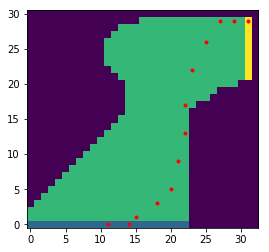

In [16]:
plt.imshow(track_np)
plt.gca().invert_yaxis()

trajectory = rts1.generate_episode()
for t in trajectory:
    plt.plot(t.state2.x, t.state2.y, '.r')